In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import argparse

try:
    from pilot.model import Model
    from pilot import data
except ImportError:
    print("failed to load pilot. PYTHONPATH: {}".format(sys.path))

/users/visics/kkelchte/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
parser = argparse.ArgumentParser(description='Main pilot that can train or evaluate online or offline from a dataset.')

# ==========================
#   Training Parameters
# ==========================
parser.add_argument("--testing", action='store_true', help="In case we're only testing, the model is tested on the test.txt files and not trained.")
parser.add_argument("--learning_rate", default=0.1, type=float, help="Start learning rate.")
parser.add_argument("--batch_size",default=16,type=int,help="Define the size of minibatches.")

# ==========================
#   Offline Parameters
# ==========================
parser.add_argument("--max_episodes",default=600,type=int,help="The maximum number of episodes (~runs through all the training data.)")

# ===========================
#   Utility Parameters
# ===========================
# Print output of ros verbose or not
parser.add_argument("--load_config", action='store_true',help="Load flags from the configuration file found in the checkpoint path.")
parser.add_argument("--verbose", action='store_false', help="Print output of ros verbose or not.")
parser.add_argument("--summary_dir", default='tensorflow/log/', type=str, help="Choose the directory to which tensorflow should save the summaries.")
parser.add_argument("--log_tag", default='testing', type=str, help="Add log_tag to overcome overwriting of other log files.")
parser.add_argument("--device", default='/gpu:0', type=str, help= "Choose to run on gpu or cpu: /cpu:0 or /gpu:0")
parser.add_argument("--random_seed", default=123, type=int, help="Set the random seed to get similar examples.")
parser.add_argument("--owr", action='store_true', help="Overwrite existing logfolder when it is not testing.")
parser.add_argument("--action_bound", default=1.0, type=float, help= "Define between what bounds the actions can go. Default: [-1:1].")
parser.add_argument("--action_dim", default=1.0, type=float, help= "Define the dimension of the actions: 1dimensional as it only turns in yaw.")
parser.add_argument("--real", action='store_true', help="Define settings in case of interacting with the real (bebop) drone.")
parser.add_argument("--evaluate", action='store_true', help="Just evaluate the network without training.")
parser.add_argument("--random_learning_rate", action='store_true', help="Use sampled learning rate from UL(10**-2, 1)")
parser.add_argument("--plot_depth", action='store_true', help="Specify whether the depth predictions is saved as images.")

# ===========================
#   Data Parameters
# ===========================
# parser.add_argument("--hdf5", action='store_true', help="Define wether dataset is hdf5 type.")
parser.add_argument("--load_data_in_ram", action='store_true', help="Define wether the dataset is preloaded into RAM.")
parser.add_argument("--dataset", default="small", type=str, help="pick the dataset in data_root from which your movies can be found.")
parser.add_argument("--data_root", default="pilot_data/",type=str, help="Define the root folder of the different datasets.")
parser.add_argument("--num_threads", default=4, type=int, help="The number of threads for loading one minibatch.")
parser.add_argument("--control_file", default='control_info.txt', type=str, help="Define the name of the file with the action labels.")
parser.add_argument("--depth_directory", default='Depth', type=str, help="Define the name of the directory containing the depth images: Depth or Depth_predicted.")
parser.add_argument("--subsample", default=1, type=int, help="Subsample data over time: e.g. subsample 2 to get from 20fps to 10fps.")

# ===========================
#   Model Parameters
# ===========================
parser.add_argument("--depth_multiplier",default=0.25,type=float, help= "Define the depth of the network in case of mobilenet.")
parser.add_argument("--network",default='mobile',type=str, help="Define the type of network: mobile, ...")
parser.add_argument("--output_size",default=[55,74],type=int, nargs=2, help="Define the output size of the depth frame: 55x74 [drone], 1x26 [turtle], only used in case of depth_q_net.")
parser.add_argument("--n_fc", action='store_true',help="In case of True, prelogit features are concatenated before feeding to the fully connected layers.")
parser.add_argument("--n_frames",default=3,type=int,help="Specify the amount of frames concatenated in case of n_fc.")
parser.add_argument("--auxiliary_depth", action='store_true',help="Specify whether a depth map is predicted.")
parser.add_argument("--discrete", action='store_true',help="Specify whether the output action space is discrete.")
# parser.add_argument("--action_quantity",default=9, type=int, help="Define the number of actions in the output layer.")

# INITIALIZATION
parser.add_argument("--checkpoint_path",default='mobilenet_025', type=str, help="Specify the directory of the checkpoint of the earlier trained model.")
parser.add_argument("--continue_training",action='store_true', help="Continue training of the prediction layers. If false, initialize the prediction layers randomly.")
parser.add_argument("--scratch", action='store_true', help="Initialize full network randomly.")

# TRAINING
parser.add_argument("--depth_weight", default=1.0, type=float, help="Define the weight applied to the depth values in the loss relative to the control loss.")
parser.add_argument("--control_weight", default=1.0, type=float, help="Define the weight applied to the control loss.")
parser.add_argument("--weight_decay",default=0.00004,type=float, help= "Weight decay of inception network")
parser.add_argument("--init_scale", default=0.0005, type=float, help= "Std of uniform initialization")
parser.add_argument("--grad_mul_weight", default=0, type=float, help="Specify the amount the gradients of prediction layers.")
parser.add_argument("--dropout_keep_prob", default=0.5, type=float, help="Specify the probability of dropout to keep the activation.")
parser.add_argument("--clip_grad", default=0, type=int, help="Specify the max gradient norm: default 0 is no clipping, recommended 4.")
parser.add_argument("--min_depth", default=0.0, type=float, help="clip depth loss with weigths to focus on correct depth range.")
parser.add_argument("--max_depth", default=5.0, type=float, help="clip depth loss with weigths to focus on correct depth range.")
parser.add_argument("--optimizer", default='adadelta', type=str, help="Specify optimizer, options: adam, adadelta, gradientdescent, rmsprop")
# parser.add_argument("--no_batchnorm_learning",action='store_false', help="In case of no batchnorm learning, are the batch normalization params (alphas and betas) not further adjusted.")
# parser.add_argument("--grad_mul", action='store_true',help="Specify whether the weights of the prediction layers should be learned faster.")
parser.add_argument("--initializer",default='xavier',type=str, help="Define the initializer: xavier or uniform [-init_scale, init_scale]")

parser.add_argument("--loss",default='mse',type=str, help="Define the loss: mse, huber or absolute")

parser.add_argument("--max_loss", default=100, type=float, help= "Define the maximum loss before it is clipped.")

parser.add_argument("--clip_loss_to_max",action='store_true', help="Over time, allow only smaller losses by clipping the maximum allowed loss to the lowest maximum loss.")

# ===========================
#   Replay Parameters
# ===========================

parser.add_argument("--replay_priority", default='no', type=str, help="Define which type of weights should be used when sampling from replay buffer: no, uniform_action, uniform_collision, td_error, state/action/target_variance, random_action")
parser.add_argument("--prioritized_keeping", action='store_true', help="In case of True, the replay buffer only keeps replay data that is most likely to be sampled.")

# ===========================
#   Rosinterface Parameters
# ===========================
parser.add_argument("--online", action='store_true', help="Training/evaluating online in simulation.")
parser.add_argument("--buffer_size", default=1000, type=int, help="Define the number of experiences saved in the buffer.")
parser.add_argument("--ou_theta", default=0.05, type=float, help= "Theta is the pull back force of the OU Noise.")
parser.add_argument("--noise", default='ou', type=str, help="Define whether the noise is temporally correlated (ou) or uniformly distributed (uni).")
parser.add_argument("--sigma_z", default=0.0, type=float, help= "sigma_z is the amount of noise in the z direction.")
parser.add_argument("--sigma_x", default=0.0, type=float, help= "sigma_x is the amount of noise in the forward speed.")
parser.add_argument("--sigma_y", default=0.0, type=float, help= "sigma_y is the amount of noise in the y direction.")
parser.add_argument("--sigma_yaw", default=0.0, type=float, help= "sigma_yaw is the amount of noise added to the steering angle.")
parser.add_argument("--speed", default=1.3, type=float, help= "Define the forward speed of the quadrotor.")
parser.add_argument("--alpha",default=0., type=float, help="Policy mixing: choose with a binomial probability of alpha for the experts policy instead of the DNN policy..")
parser.add_argument("--epsilon",default=0, type=float, help="Apply epsilon-greedy policy for exploration.")
parser.add_argument("--epsilon_decay", default=0.0, type=float, help="Decay the epsilon exploration over time with a slow decay rate of 1/10.")
parser.add_argument("--prefill", action='store_true', help="Fill the replay buffer first with random (epsilon 1) flying behavior before training.")

parser.add_argument("--off_policy",action='store_true', help="In case the network is off_policy, the control is published on supervised_vel instead of cmd_vel.")
parser.add_argument("--dont_show_depth",action='store_true', help="Publish the predicted horizontal depth array to topic ./depth_prection so show_depth can visualize this in another node.")

parser.add_argument("--grad_steps", default=10, type=int, help="Define the number of batches or gradient steps are taken between 2 runs.")

parser.add_argument("--field_of_view", default=104, type=int, help="The field of view of the camera cuts the depth scan in the range visible for the camera. Value should be even. Normal: 72 (-36:36), Wide-Angle: 120 (-60:60)")
parser.add_argument("--smooth_scan", default=4, type=int, help="The 360degrees scan has a lot of noise and is therefore smoothed out over 4 neighboring scan readings")

FLAGS, others = parser.parse_known_args()
FLAGS.summary_dir = os.path.join(os.getenv('HOME'),FLAGS.summary_dir)


In [3]:
# Define model and data
FLAGS.checkpoint_path = 'doshico_drone/scratch'

In [4]:
# Load model in tensorflow session
config=tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
model = Model(FLAGS, sess)

checkpoint: /esat/opal/kkelchte/docker_home/tensorflow/log/doshico_drone/scratch
INFO:tensorflow:Var MobilenetV1/aux_depth/fully_connected/weights has no gradient
INFO:tensorflow:Var MobilenetV1/aux_depth/fully_connected/biases has no gradient
INFO:tensorflow:Var MobilenetV1/aux_depth/fully_connected_1/weights has no gradient
INFO:tensorflow:Var MobilenetV1/aux_depth/fully_connected_1/biases has no gradient
INFO:tensorflow:Var MobilenetV1/aux_depth/fully_connected_2/weights has no gradient
INFO:tensorflow:Var MobilenetV1/aux_depth/fully_connected_2/biases has no gradient
Successfully loaded model from:/esat/opal/kkelchte/docker_home/tensorflow/log/doshico_drone/scratch


In [5]:
grads={}
# Define input gradients for each layer:
for l in sorted(model.endpoints.keys()):
    if l in ["Conv2d_0",
            "Conv2d_1_depthwise",
            "Conv2d_1_pointwise",
            "Conv2d_2_depthwise",
            "Conv2d_2_pointwise",
            "Conv2d_3_depthwise",
            "Conv2d_3_pointwise",
            "Conv2d_4_depthwise",
            "Conv2d_4_pointwise",
            "Conv2d_5_depthwise",
            "Conv2d_5_pointwise",
            "Logits"]:
        print l, model.endpoints[l].shape 
        # and each filter
        if len(model.endpoints[l].shape)==2: #Add the logits
            with tf.device('/cpu:0'):
                layer_loss = tf.reduce_mean(model.endpoints[l][:,0])
                gradients = tf.gradients(layer_loss, model.inputs)[0]
                gradients /= (tf.sqrt(tf.reduce_mean(tf.square(gradients))) + 1e-5)
                grads[l]=gradients
        else: #add all filters incase of no-logit layer
#             for f in range(model.endpoints[l].shape[-1]):
            for f in [0]:
                with tf.device('/cpu:0'):
                    layer_loss=tf.reduce_mean(model.endpoints[l][:,:,:,f])
                    gradients = tf.gradients(layer_loss, model.inputs)[0]
                    gradients /= (tf.sqrt(tf.reduce_mean(tf.square(gradients))) + 1e-5)
                    grads[l+"_"+str(f)]=gradients
print grads.keys()

# Let's define a loss function that will seek to maximize the activation of a specific filter (filter_index) in a specific layer (layer_name)
# model.endpoints.keys()
# layer='Conv2d_4_pointwise'
# layer='Logits'
# filter_index=0

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
# layer_output=model.endpoints[layer][:,:,:,filter_index]
# layer_output=model.endpoints[layer][:,filter_index]
# layer_loss = tf.reduce_mean(layer_output)


# compute the gradient of the input picture wrt this loss
# grads = tf.gradients(layer_loss, model.inputs)[0]

# normalization trick: we normalize the gradient
# grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)




Conv2d_0 (?, 64, 64, 8)
Conv2d_1_depthwise (?, 64, 64, 8)
Conv2d_1_pointwise (?, 64, 64, 16)
Conv2d_2_depthwise (?, 32, 32, 16)
Conv2d_2_pointwise (?, 32, 32, 32)
Conv2d_3_depthwise (?, 32, 32, 32)
Conv2d_3_pointwise (?, 32, 32, 32)
Conv2d_4_depthwise (?, 16, 16, 32)
Conv2d_4_pointwise (?, 16, 16, 64)
Conv2d_5_depthwise (?, 16, 16, 64)
Conv2d_5_pointwise (?, 16, 16, 64)
Logits (?, 1)
['Conv2d_3_pointwise_0', 'Conv2d_1_depthwise_0', 'Conv2d_2_pointwise_0', 'Conv2d_4_pointwise_0', 'Conv2d_2_depthwise_0', 'Conv2d_1_pointwise_0', 'Conv2d_5_depthwise_0', 'Conv2d_5_pointwise_0', 'Conv2d_3_depthwise_0', 'Conv2d_0_0', 'Logits', 'Conv2d_4_depthwise_0']


In [24]:
import time
import matplotlib.image as mpimg
import skimage.transform as sm
im_size=(128,128)

stime=time.time()
# create an input for each filter in each layer
inputs={}
for g in sorted(grads.keys()):
    # inputs[g]=np.random.random((1, model.input_size[1], model.input_size[2], model.input_size[3])) * 20 + 128.
#     img=mpimg.imread('/esat/opal/kkelchte/docker_home/pilot_data/doshico_drone/00000_sandbox/RGB/0000000061.jpg')
    img=mpimg.imread('/esat/opal/kkelchte/docker_home/pilot_data/doshico_drone/00005_forest/RGB/0000000061.jpg')
    scale_height = int(np.floor(img.shape[0]/im_size[0]))
    scale_width = int(np.floor(img.shape[1]/im_size[1]))
    img = img[::scale_height,::scale_width]
    inputs[g] = np.expand_dims(sm.resize(img,im_size,mode='constant').astype(float),0)


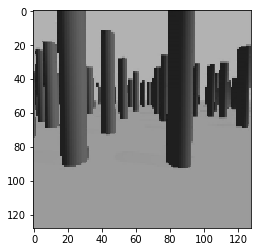

In [26]:

img=mpimg.imread('/esat/opal/kkelchte/docker_home/pilot_data/doshico_drone/00005_forest/RGB/0000000061.jpg')
scale_height = int(np.floor(img.shape[0]/im_size[0]))
scale_width = int(np.floor(img.shape[1]/im_size[1]))
img = img[::scale_height,::scale_width]
plt.imshow(sm.resize(img,im_size,mode='constant').astype(float))
plt.show()



In [30]:
step=10
n=100
for n in range(n):
    print "{0} step: {1}".format(time.ctime(), n)
    for i,g in enumerate(sorted(grads.keys())):
#         print("{3}: {0}/{1} : {2}".format(i+1,len(grads.keys()),g, time.ctime()))
        inputs[g] += step * sess.run(grads[g], {model.inputs: inputs[g]})
# n=3
# for i in range(n):
#     if i%100 == 0: print "{0}/{1}".format(i,n)
#     grads_value = sess.run([grads[g] for g in grads.keys()], {model.inputs:input_img_data})
#     input_img_data += grads_value*step_size

Mon Jul 23 15:59:25 2018 step: 0
Mon Jul 23 15:59:25 2018 step: 1
Mon Jul 23 15:59:25 2018 step: 2
Mon Jul 23 15:59:25 2018 step: 3
Mon Jul 23 15:59:26 2018 step: 4
Mon Jul 23 15:59:26 2018 step: 5
Mon Jul 23 15:59:26 2018 step: 6
Mon Jul 23 15:59:26 2018 step: 7
Mon Jul 23 15:59:26 2018 step: 8
Mon Jul 23 15:59:26 2018 step: 9
Mon Jul 23 15:59:27 2018 step: 10
Mon Jul 23 15:59:27 2018 step: 11
Mon Jul 23 15:59:27 2018 step: 12
Mon Jul 23 15:59:27 2018 step: 13
Mon Jul 23 15:59:27 2018 step: 14
Mon Jul 23 15:59:27 2018 step: 15
Mon Jul 23 15:59:28 2018 step: 16
Mon Jul 23 15:59:28 2018 step: 17
Mon Jul 23 15:59:28 2018 step: 18
Mon Jul 23 15:59:28 2018 step: 19
Mon Jul 23 15:59:28 2018 step: 20
Mon Jul 23 15:59:28 2018 step: 21
Mon Jul 23 15:59:28 2018 step: 22
Mon Jul 23 15:59:29 2018 step: 23
Mon Jul 23 15:59:29 2018 step: 24
Mon Jul 23 15:59:29 2018 step: 25
Mon Jul 23 15:59:29 2018 step: 26
Mon Jul 23 15:59:29 2018 step: 27
Mon Jul 23 15:59:29 2018 step: 28
Mon Jul 23 15:59:30 2018

In [28]:
import matplotlib.pyplot as plt

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

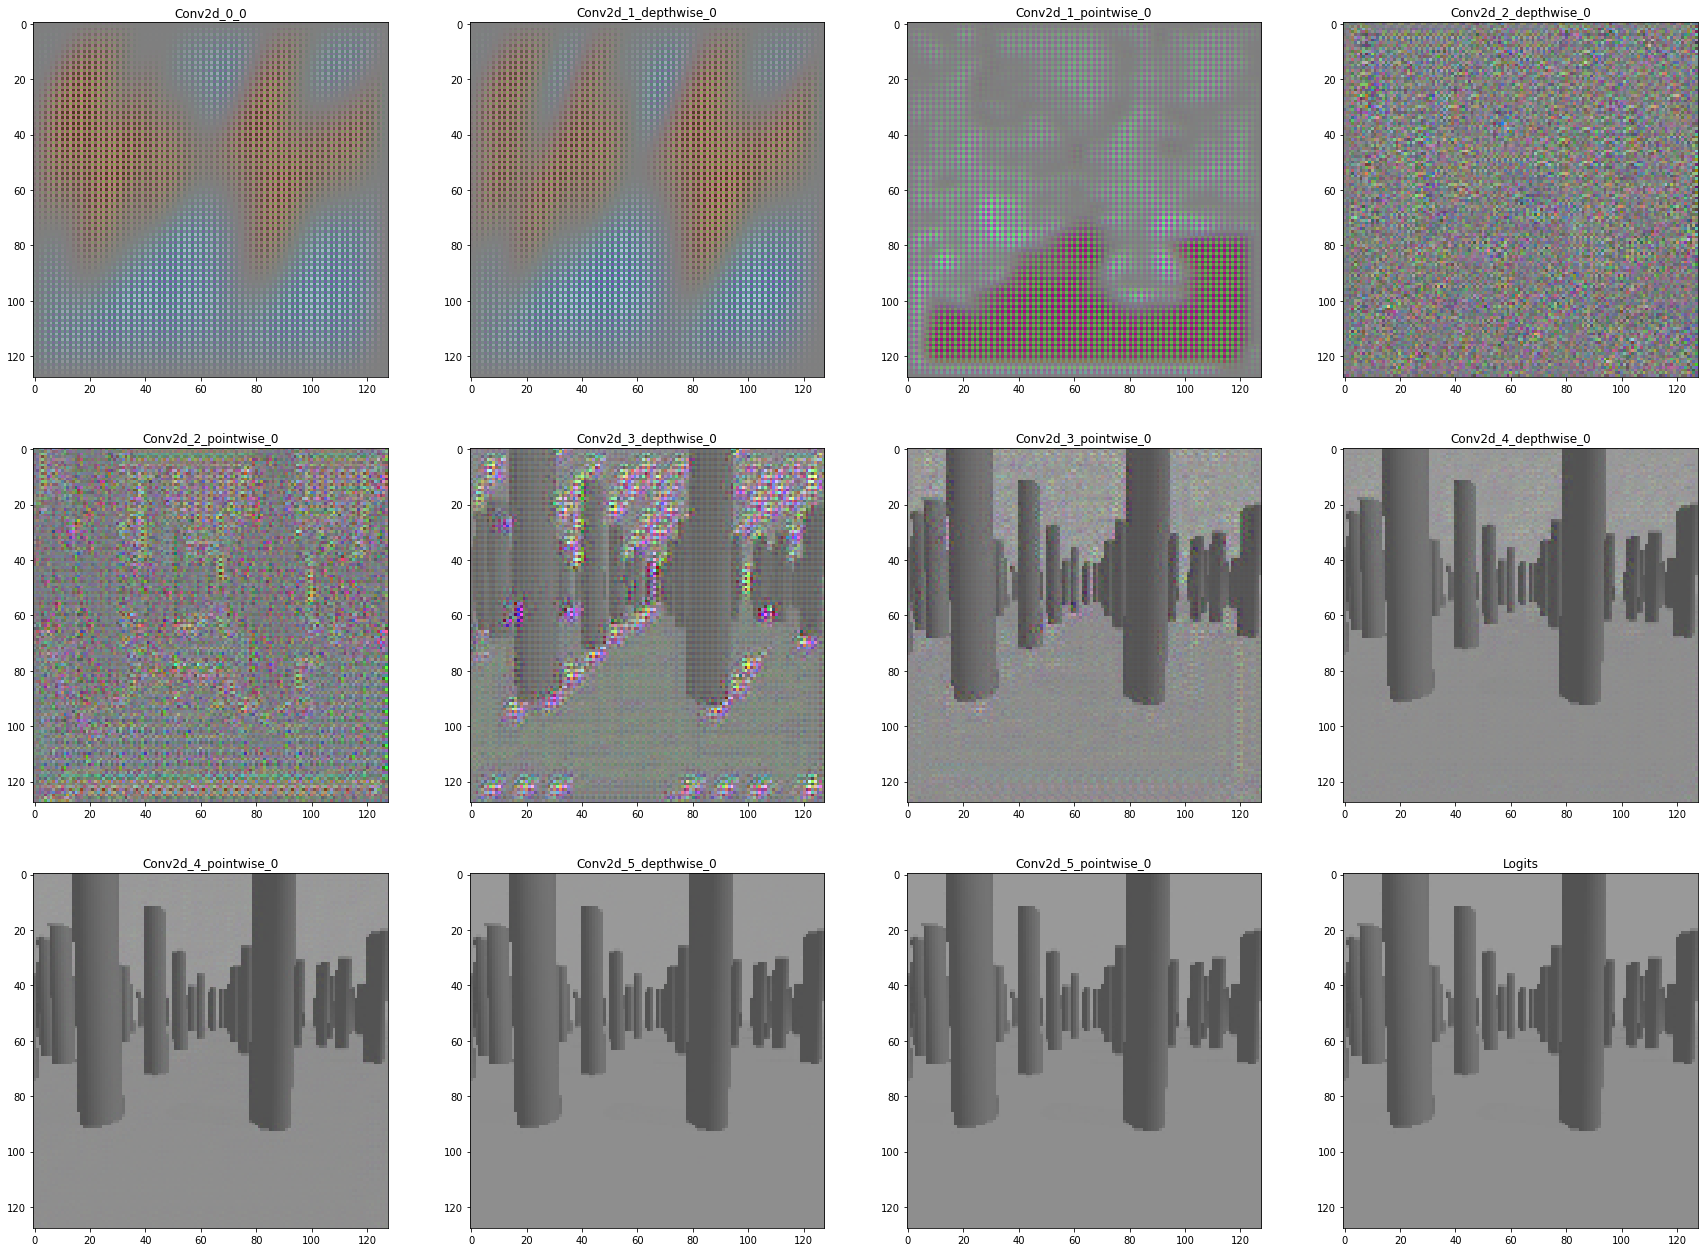

In [31]:
fig=plt.figure(figsize=(30,30))
for i, g in enumerate(sorted(inputs.keys())):
    img = deprocess_image(inputs[g][0])
    plt.subplot(int(len(inputs)/4)+1,4,i+1)
    plt.title(g)
    plt.imshow(img)
plt.show()

In [41]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, model.input_size[1], model.input_size[2], model.input_size[3])) * 20 + 128.
# run gradient ascent for 20 steps
n=2000
for i in range(n):
    if i%100 == 0: print "{0}/{1}".format(i,n)
    grads_value = sess.run(grads, {model.inputs:input_img_data})
    input_img_data += grads_value*step_size

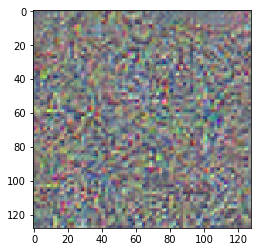

In [42]:

img = input_img_data[0]
img = deprocess_image(img)
plt.imshow(img)
plt.show()
# imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

In [7]:
# Merge some stuff together:
# Looping over layers:
for l in sorted(model.endpoints.keys()):
    if not "aux_depth" in l:
        print l
        

AvgPool_1a
Conv2d_0
Conv2d_10_depthwise
Conv2d_10_pointwise
Conv2d_11_depthwise
Conv2d_11_pointwise
Conv2d_12_depthwise
Conv2d_12_pointwise
Conv2d_13_depthwise
Conv2d_13_pointwise
Conv2d_1_depthwise
Conv2d_1_pointwise
Conv2d_2_depthwise
Conv2d_2_pointwise
Conv2d_3_depthwise
Conv2d_3_pointwise
Conv2d_4_depthwise
Conv2d_4_pointwise
Conv2d_5_depthwise
Conv2d_5_pointwise
Conv2d_6_depthwise
Conv2d_6_pointwise
Conv2d_7_depthwise
Conv2d_7_pointwise
Conv2d_8_depthwise
Conv2d_8_pointwise
Conv2d_9_depthwise
Conv2d_9_pointwise
Logits
